In [20]:
! pip install transformers==4.31.0 -q

# 1.Import necessary libraries and get filenames

In [21]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from transformers import ViTImageProcessor, ViTForImageClassification

In [6]:
!unzip /content/drive/MyDrive/AIO/image_retrieval_dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: images_mr/5415.jpg      
  inflating: images_mr/5416.jpg      
  inflating: images_mr/5417.jpg      
  inflating: images_mr/5418.jpg      
  inflating: images_mr/5419.jpg      
  inflating: images_mr/542.jpg       
  inflating: images_mr/5420.jpg      
  inflating: images_mr/5421.jpg      
  inflating: images_mr/5422.jpg      
  inflating: images_mr/5423.jpg      
  inflating: images_mr/5424.jpg      
  inflating: images_mr/5425.jpg      
  inflating: images_mr/5426.jpg      
  inflating: images_mr/5427.jpg      
  inflating: images_mr/5428.jpg      
  inflating: images_mr/5429.jpg      
  inflating: images_mr/543.jpg       
  inflating: images_mr/5430.jpg      
  inflating: images_mr/5431.jpg      
  inflating: images_mr/5432.jpg      
  inflating: images_mr/5433.jpg      
  inflating: images_mr/5434.jpg      
  inflating: images_mr/5435.jpg      
  inflating: images_mr/5436.jpg      
  inflating: images_mr/5437.jpg

# 2.Load data

In [22]:
dataset_dir = '/content/images_mr'
image_filenames = os.listdir(dataset_dir)

In [23]:
src_images = []

In [24]:
dataset_dir = 'images_mr'
image_filenames = os.listdir(dataset_dir)[:500]
scr_images = []
for filename in image_filenames:
  filepath = os.path.join(dataset_dir, filename)
  image = cv2.imread(filepath)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  src_images.append(image)

# 3.Define Preprocessing function

## 3.1 ViT Processor

In [51]:
device = 'cpu'
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")


In [52]:
def preprocessing(images):
    inputs = processor(
        images,
        return_tensors='pt'
    ).to(device)

    with torch.no_grad():
        output = model(
            **inputs,
            output_hidden_states=True
        ).hidden_states#[-1][:, 0, :].detach().cpu().numpy()

    return output


In [53]:
preprocessed_src_images = preprocessing(src_images)


# 4.Define Cosimilarity Metrics

In [38]:
def mean_absolute_error(query_vector, src_vectors):
    abs_diff = np.abs(src_vectors - query_vector)
    mae = np.mean(abs_diff, axis=1)
    return mae

def mean_squared_error(query_vector, src_vectors):
    squared_diff = (src_vectors - query_vector) ** 2
    mse = np.mean(squared_diff, axis=1)
    return mse

def cosine_similarity(query_vector, src_vectors):
    query_norm = np.linalg.norm(query_vector)
    normalized_query = query_vector / query_norm
    src_norms = np.linalg.norm(src_vectors, axis=1)
    normalized_src = src_vectors / src_norms[:, np.newaxis]
    cosine_similarity = np.dot(normalized_src, normalized_query)
    return cosine_similarity

def correlation_coefficient(query_vector, src_vectors):
    return np.corrcoef(query_vector, src_vectors)[:-1, -1]

# 5.Ranking

In [39]:
def ranking(preprocessed_query_image, preprocessed_src_images, top_k=10):
    scores = cosine_similarity(preprocessed_query_image, preprocessed_src_images)
    ranked_list = np.argsort(scores)[::-1][:top_k]
    scores = scores[ranked_list]
    return ranked_list, scores

# 6.Predict

Query Image


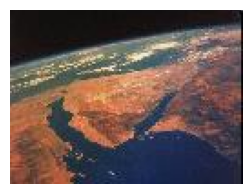

Top 10 results


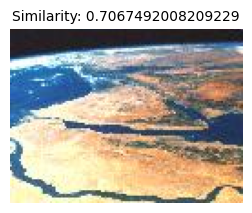

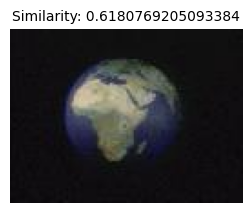

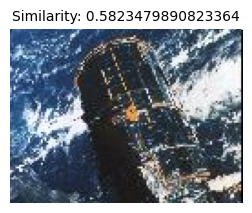

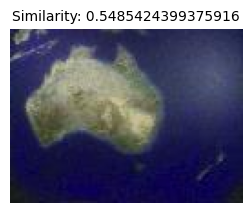

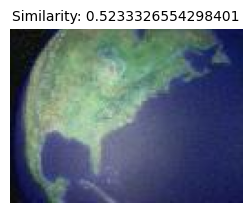

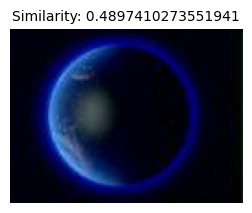

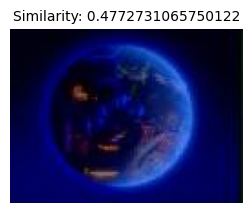

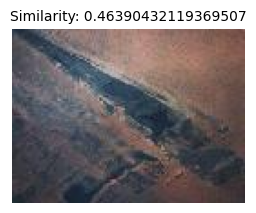

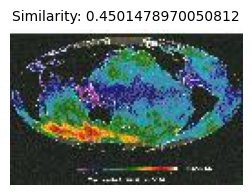

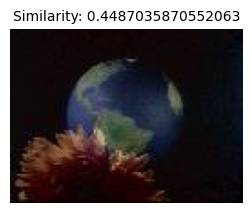

In [63]:
query_image_paths = [
    '/content/images_mr/615.jpg'
]

top_k = 10

for query_image_path in query_image_paths:
    query_image = cv2.imread(query_image_path, 1)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    preprocessed_query_image = preprocessing(query_image).squeeze(0)

    ranked_list, scores = ranking(preprocessed_query_image, preprocessed_src_images, top_k)

    print('Query Image')
    plt.figure(figsize=(3, 3))
    plt.imshow(query_image)
    plt.axis('off')
    plt.show()

    print(f'Top {top_k} results')
    for idx in range(len(ranked_list)):
        src_image_idx = ranked_list[idx]
        similarity_score = scores[idx]
        plt.figure(figsize=(3, 3))
        plt.imshow(src_images[src_image_idx])
        plt.title(f'Similarity: {similarity_score}', fontsize=10)
        plt.axis('off')
        plt.show()